In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [17]:
data = pd.read_csv(r"C:\Users\Shubham\.cache\kagglehub\datasets\yasserh\song-popularity-dataset\versions\1\song_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [18]:
data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [19]:
data.nunique()

song_name           13070
song_popularity       101
song_duration_ms    11771
acousticness         3209
danceability          849
energy               1132
instrumentalness     3925
key                    12
liveness             1425
loudness             8416
audio_mode              2
speechiness          1224
tempo               12112
time_signature          5
audio_valence        1246
dtype: int64

In [20]:
X = data.iloc[:, 2:]
Y = data.iloc[:,1]
print(X.shape, Y.shape)

(18835, 13) (18835,)


In [21]:
X = np.array(X, dtype = np.float64)
Y= np.array(Y, dtype = np.float64).reshape(-1,1)
print(X.shape, Y.shape)

(18835, 13) (18835, 1)


In [22]:
scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [23]:
print(torch.cuda.is_available())

True


# Model LR_preceptron : 
### This is a Linear Regression Model with only one neuron. it has following features 
- it's written with pytorch to have gpu acceleration
- it computes forward and backward propogation from scratch
- it uses 
    1. Early stopping
    2. Regularization
    3. extracting best weights 
    4. validation set during training

In [70]:
class LR_preceptron():
    def __init__(self, samples, features, lr = 0.01, epochs = 10000, patience = 50, min_delta = 1e-6, lambda_reg = 0.01):
        # making only a single precptron with linear regression
        self.W = torch.randn(features,1).to("cuda")  #shape of weights (d, 1) 
        self.b = torch.randn(1).to("cuda")      #shape of b depends on the number of neurons here only 1
        self.lr = lr
        self.epochs = epochs
        self.min_delta = 1e-6
        self.patience = patience
        self.lambda_reg = lambda_reg
    
    def predict(self, X):
        return X@self.W + self.b      #output is (n , d)*(d,1) + 1 = (n,1), it is our y_predicted shape
    
    def predict_transform(self, X, Y):
        X = torch.tensor(X, dtype = torch.float32).to("cuda")
        Y = torch.tensor(Y, dtype = torch.float32).to("cuda")
        y_pred = self.predict(X)
        return self.MSE(y_pred, Y)
    
    def MSE(self, y, y_pred):
        return torch.mean((y_pred - y)**2)/2 + self.lambda_reg*torch.linalg.norm(self.W)**2 #returns a scaler value
    
    def fit(self, X, Y):

        X = torch.tensor(X, dtype = torch.float32).to("cuda")
        Y = torch.tensor(Y, dtype = torch.float32).to("cuda")

        best_weight = self.W.detach().clone()
        best_bias  = self.b.detach().clone()

        best_val_loss = float("inf")

        train_loss = []  #for storing the loss at each iteration
        val_loss = []    #for storing the val_loss at each iteration

        patience = self.patience
        iteration_point = 0

        x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True) #using cross validatiion set at each iteration
        n = x_train.shape[0]

        for _ in range(self.epochs):
            
            #forward pass 
            y_pred = self.predict(x_train)
            y_val_pred = self.predict(x_val)
            #loss calculation          
            loss_t = self.MSE(y_train, y_pred)
            loss_v = self.MSE(y_val, y_val_pred)

            #checking for the best weights and bias
            if  best_val_loss - loss_v > self.min_delta: 
                iteration_point = _
                best_val_loss = loss_v
                best_weight = self.W.clone()
                best_bias = self.b.clone()
                
                patience = self.patience
            else : patience -= 1
            if patience == 0:
                print(f"stopping at iteration {_}, with best val loss as {best_val_loss} found at {iteration_point}")
                break
            #appending the loss
            train_loss.append(loss_t.item())
            val_loss.append(loss_v.item()) #item() is used to convert the tensor to a scaler value
            
            if _ % 100 == 0:
                print(f"Epoch {_}: train_loss = {loss_t.item()}, val_loss = {loss_v.item()}")
            #backward pass 
            dL = (y_pred - y_train)  #size is (n,1)
            dW = (x_train.T@dL)/n         # size is (d, n)(n, 1) = (d, 1)
            db = torch.sum(dL)/n    #output is scaler
            self.W -= self.lr*dW
            self.b -= self.lr*db

        self.W = best_weight
        self.b = best_bias
        
        plt.plot(train_loss, color = 'blue', label = 'train_loss')
        plt.plot(val_loss, color = 'red', label = 'val_loss')
        plt.xlabel("iterations")
        plt.ylabel("loss")
        plt.title("loss vs iterations")
        plt.legend()
        plt.show()


Epoch 0: train_loss = 1642.640869140625, val_loss = 1625.35498046875
Epoch 100: train_loss = 421.3020324707031, val_loss = 409.25830078125
Epoch 200: train_loss = 256.6500549316406, val_loss = 246.306884765625
Epoch 300: train_loss = 234.22314453125, val_loss = 224.6692352294922
Epoch 400: train_loss = 231.0939178466797, val_loss = 221.91249084472656
Epoch 500: train_loss = 230.62635803222656, val_loss = 221.62454223632812
stopping at iteration 579, with best val loss as 221.61859130859375 found at 529


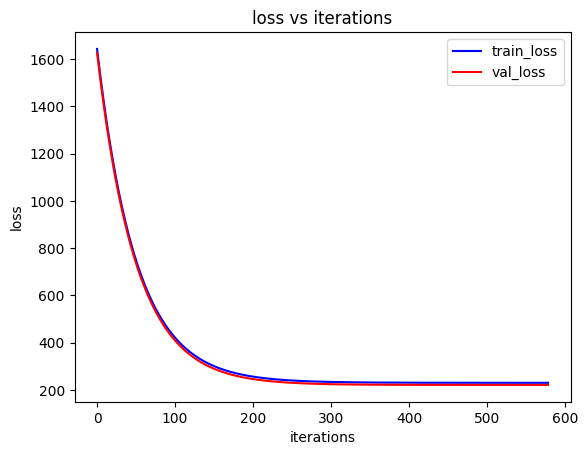

231.0688018798828

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.2, shuffle = True, random_state= 42)
n, f = x_train.shape
model_1 = LR_preceptron(n, f)
model_1.fit(x_train, y_train)
loss = model_1.predict_transform(x_test, y_test)
loss.item()


# Model ANN_regression : 
### This is a Linear Regression Model with only multiple layer supporting multiple neurons. it has following features 
- it's written with pytorch to have gpu acceleration
- it computes forward and backward propogation from scratch
- it uses 
    1. Early stopping
    2. Regularization
    3. extracting best weights 
    4. validation set during training

In [76]:
class ANN_regression:
    def __init__(self, l , lr = 0.001, epochs = 10000, min_delta = 1e-6, patience = 50, lambda_reg = 0.01):
        #l = [input_dim, hidden_dim1, hidden_dim2, ..., output_dim]
        self.epochs = epochs
        self.lr = lr
        self.min_delta = min_delta
        self.patience = patience
        self.lambda_reg = lambda_reg
        self.layers = len(l)-2
        self.W = [] #list to store weights of each layer
        self.b = [] #lsit to store the bias of each layer
        
        #loop to intialize weights will run from pos 1 to 3
        for i in range(0, len(l)-1): 
            w = torch.randn(l[i], l[i+1], dtype = torch.float32).to("cuda") # create a (d, hidden_layer_nurons) matrix 
            _b = torch.randn(l[i+1], dtype = torch.float32).to("cuda") #create a (hidden_layer_nurons, ) array
            self.W.append(w) #self.W[0] corrosponds to 1st hidden layer weights
            self.b.append(_b) #self.b[0] corrosponds to 1st hidden layer bias

    def relu(self, z):
        return torch.relu(z)

    def d_relu(self, z):
        return (z > 0).type_as(z)
    
    def elu(self, z, alpha = 1.0):
        return torch.where(z > 0, z, alpha*(torch.exp(z).to(z.device) - 1))
    
    def d_elu(self, z, alpha = 1.0):
        return torch.where(z > 0, torch.tensor(1.0).to(z.device), alpha * torch.exp(z))
    
    def MSE(self, y_pred, y):

        reg = self.lambda_reg * sum(torch.sum(w ** 2) for w in self.W)

        return torch.mean((y_pred - y)**2) + reg
    
    def forward_pass(self, X, Y):
        A = []        #will store activation function passed layers output, but initial is X
        A.append(X)
        Z = []         #will store output of hidden layers
        for i in range(self.layers): #will run for each hidden layer

            z = A[i]@self.W[i] + self.b[i] #calculates each hidden layer output

            a = self.relu(z)  #calculates activation function applied on each layer

            Z.append(z)   #stores each hidden layer output
            A.append(a)  #stores each activated output

        #final layer output need to be added to Z, it doesn't have any activation function
        Z.append(A[self.layers]@self.W[self.layers] + self.b[self.layers])
        
        #loss calculation
        loss = self.MSE(Z[self.layers], Y) 

        return A, Z, loss
    
    def backward_pass(self, n, a, z, loss, y):
         
        dL = (z[self.layers] - y) #(n,1)

        dW_last = (a[self.layers].T@dL)/n
        dW_last += 2 * self.lambda_reg * self.W[self.layers]
        db_last = torch.sum(dL, dim = 0)/n

        self.W[self.layers] -= self.lr*dW_last
        self.b[self.layers] -= self.lr*db_last

        for i in range(self.layers-1, -1, -1):
            dL = (dL @ self.W[i + 1].T) * self.d_relu(z[i])
            dW = a[i].T @ dL / n
            dW += 2 * self.lambda_reg * self.W[i]
            db = torch.sum(dL, dim=0) / n
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    
    def fit(self, X, Y):

        train_loss = [] #stores each iteration loss
        val_loss = [] #stores each iteration validation loss

        #variables for early stopping
        best_val_loss = float("inf")
        best_weights = [w.detach().clone() for w in self.W]
        best_bias = [b.detach().clone() for b in self.b]
        patience = self.patience
        itr = 0
        x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True)
        #convert inputs to torch tensors for gpu accelerated outputs
        x_train = torch.as_tensor(x_train, dtype = torch.float32).to("cuda")
        y_train = torch.as_tensor(y_train, dtype = torch.float32).to("cuda")
        samples_n = x_train.shape[0]
        #split a validation set
       
        
        for _ in range(self.epochs):
            
            
            # forward pass
            A_train, Z_train, loss_train = self.forward_pass(x_train, y_train) 
            loss_val = self.predict(x_val, y_val)

            #storing the losses 
            train_loss.append(loss_train.item())
            val_loss.append(loss_val.item())

            if _% 1000 == 0: 
                print(f"iteration {_}, training loss {loss_train.item()}, validation_loss {loss_val.item()}")
                
            #Early_stopping
            if best_val_loss - loss_val >  self.min_delta:
                best_val_loss = loss_val
                best_weights = [w.detach().clone() for w in self.W]
                best_bias = [b.detach().clone() for b in self.b]
                itr = _
                patience = self.patience 
            else : 
                patience -= 1
                if patience == 0:
                    print(f"stopping at iteration {_}, best weights for validation loss minimization found at {itr}")
                    break

            #backward pass 
            self.backward_pass(samples_n, A_train, Z_train, loss_train, y_train)
        
        #assigning best weights and bias back
        self.W = best_weights
        self.b = best_bias

        #plotting the loss vs iteration curve
        plt.plot(train_loss, color = "blue", label = "training loss")
        plt.plot(val_loss, color = "red", label = "validation loss")
        plt.yscale('log')
        plt.xlabel("iterations")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

    def predict(self, x, y):
        x = torch.as_tensor(x, dtype=torch.float32).to("cuda")
        y = torch.as_tensor(y, dtype=torch.float32).to("cuda")
        A, Z, loss = self.forward_pass(x, y)
        return loss


iteration 0, training loss 3173.93798828125, validation_loss 3234.88232421875
iteration 1000, training loss 448.55224609375, validation_loss 432.2704772949219
iteration 2000, training loss 445.6582946777344, validation_loss 429.7444763183594
iteration 3000, training loss 443.9978332519531, validation_loss 428.7748107910156
stopping at iteration 3054, best weights for validation loss minimization found at 3004


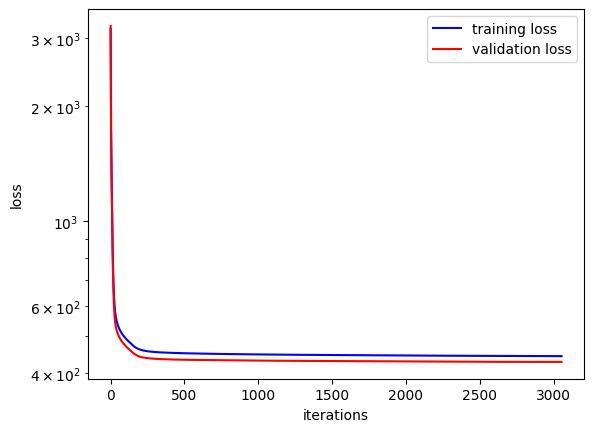

449.0412902832031

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.2, shuffle = True, random_state= 42)
n, f = x_train.shape
layers = [13,6,3,1]
model_2 = ANN_regression(layers)
model_2.fit(x_train, y_train)
loss = model_2.predict(x_test, y_test)
loss.item()


# Model ANN_reg_grad : 
### This is a Linear Regression Model with multiple layers and mulitple neurons, and uses ReLU for activation in hidden layers . it has following features 
- it's written with pytorch to have gpu acceleration
- it computes forward propogation from scratch and uses auto grad for back propogations
- it uses 
    1. Early stopping
    2. Regularization
    3. extracting best weights 
    4. validation set during training
    5. mini-batch adam optimization

In [74]:
class ANN_reg_grad:
    def __init__(self, layers, lr = 0.01, epochs = 1000, min_delta = 1e-6, patience = 50, lambda_reg = 0.1):
        
        self.hidden_layers = len(layers) - 2   #number of hidden layers for l = [13,1] hidden layers = 0 , final layer position 0
        self.final_layer = len(layers) - 2     #final layer position in weights and biases lists which happens to be equal to number of
                                            #hidden layers as numbering starts from 0 so 0 and 1 are hidden layers weights and 2 is the final layers weights 
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8


        self.lr = lr   
        self.epochs = epochs
        self.min_delta = min_delta
        self.patience = patience
        self.lambda_reg = lambda_reg
                                      #storing weights in lists and initailizing those weights
        self.W = []
        self.b = []

        for i in range(len(layers)-1): # loop runs from 0 to len(layers)-2 i.e if length is 4 then to 0,1,2
            w = torch.randn(layers[i], layers[i+1], dtype = torch.float32, device = "cuda", requires_grad = True)
            B = torch.randn(layers[i+1], dtype = torch.float32, device = "cuda", requires_grad = True)
            self.W.append(w)
            self.b.append(B)

        self.m_w = [torch.zeros_like(w) for w in self.W]  # first moment (mean)
        self.v_w = [torch.zeros_like(w) for w in self.W]  # second moment (variance)
        self.m_b = [torch.zeros_like(b) for b in self.b]
        self.v_b = [torch.zeros_like(b) for b in self.b]
    
    def MSE(self, y_pred, y):
        reg = self.lambda_reg * sum(torch.sum(w ** 2) for w in self.W)
        return torch.mean((y_pred-y)**2)/2 + reg

    def forward(self, x):
        for i in range(self.hidden_layers):
            x = x@self.W[i] + self.b[i]
            x = torch.relu(x)
        y_pred = x@self.W[self.final_layer] + self.b[self.final_layer]
        return y_pred
    
    def backward(self, loss):
        loss.backward()
        dw = []
        db = []
        for i in range(self.hidden_layers+1):
            dw.append(self.W[i].grad.clone())
            db.append(self.b[i].grad.clone())
            self.W[i].grad.zero_()
            self.b[i].grad.zero_()
        return dw, db
    
    

    def fit(self, x, y):
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 32)

        x_train = torch.tensor(x_train, dtype = torch.float32, device = "cuda")
        y_train = torch.tensor(y_train, dtype = torch.float32, device = "cuda")
        

        
        dataset = TensorDataset(x_train, y_train)
        
        train_loss = []
        val_loss = []

        

        best_weights = [w.detach().clone() for w in self.W]
        best_bias = [b.detach().clone() for b in self.b]

        best_loss = float("inf")
        patience = self.patience
        itr = 0
        
        for _ in range(self.epochs):
            
            dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)
            epoch_loss = 0

            for x_batch, y_batch in dataloader:
            
                #forward pass
                y_pred = self.forward(x_batch)

                #loss calculation
                loss_t = self.MSE(y_pred, y_batch)
               
                
                #storing losses for plotting 
                epoch_loss += loss_t.item()
                

                #backward pass
                dw, db = self.backward(loss_t)

                #weight and bias updation
                t = _ + 1  # timestep for bias correction
                for i in range(self.hidden_layers + 1):
                    # Update biased first moment estimate
                    self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                    self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                    
                    # Update biased second raw moment estimate
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)
                    
                    # Compute bias-corrected estimates
                    m_w_hat = self.m_w[i] / (1 - self.beta1 ** t)
                    v_w_hat = self.v_w[i] / (1 - self.beta2 ** t)
                    m_b_hat = self.m_b[i] / (1 - self.beta1 ** t)
                    v_b_hat = self.v_b[i] / (1 - self.beta2 ** t)
                    
                    # Update weights and biases
                    with torch.no_grad():
                        self.W[i] -= self.lr * m_w_hat / (torch.sqrt(v_w_hat) + self.eps)
                        self.b[i] -= self.lr * m_b_hat / (torch.sqrt(v_b_hat) + self.eps)

            
            
            loss_v = self.predict(x_val, y_val)
            val_loss.append(loss_v.item())
            n = x_train.shape[0]
            total_batches = n/64
            train_loss.append(epoch_loss/total_batches)

            if _ % 40 == 0: 
                print(f"iteration {_}/{self.epochs}, training_loss {epoch_loss/total_batches}, validation_loss {loss_v}")
            
            #early_stopping
            if best_loss - loss_v > self.min_delta:
                best_loss = loss_v
                best_weights = [w.detach().clone() for w in self.W]
                best_bias = [b.detach().clone() for b in self.b]
                itr = _
                patience = self.patience
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early Stopping at iteration {_}, best weights found at iteration {itr}")
                    break
        
        #restoring best weights and biases
        self.W = best_weights
        self.b = best_bias

        #plotting loss vs iteration curve
        plt.plot(train_loss, color = "blue", label = "training_loss")
        plt.plot(val_loss, color = "red", label = "validation_loss")
        plt.yscale('log')
        plt.xlabel("Iterations")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
    
    def predict(self, x, y):
        x = torch.tensor(x, dtype = torch.float32, device = "cuda")
        y = torch.tensor(y, dtype = torch.float32, device = "cuda")
        y_pred = self.forward(x)
        loss = self.MSE(y_pred, y)
        return loss






iteration 0/1000, training_loss 1012.7968916892214, validation_loss 327.36944580078125
iteration 40/1000, training_loss 228.02235820967107, validation_loss 229.7247772216797
iteration 80/1000, training_loss 224.883356276962, validation_loss 227.4537353515625
iteration 120/1000, training_loss 223.92200689345862, validation_loss 225.95571899414062
iteration 160/1000, training_loss 223.58904185721545, validation_loss 226.23133850097656
Early Stopping at iteration 175, best weights found at iteration 125


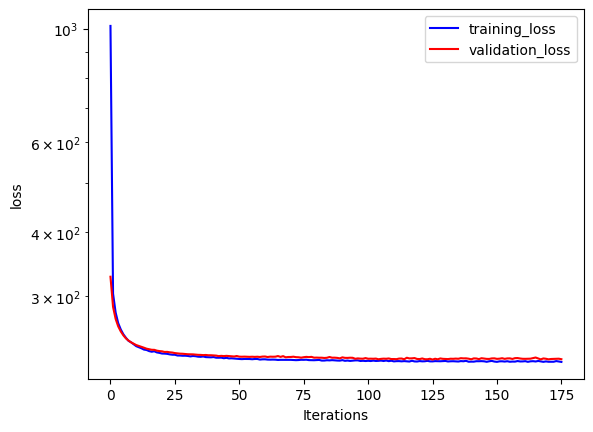

226.43148803710938

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.2, shuffle = True, random_state= 42)
n, f = x_train.shape
layers = [13,6,3,1]
model_3 = ANN_reg_grad(layers)
model_3.fit(x_train, y_train)
loss = model_3.predict(x_test, y_test)
loss.item()